In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
df = pd.read_csv("P:\SSM project\Datasets\SSH\ssh_logs_processed.csv")  # Replace with your filename

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_18884\1178461911.py:1: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv("P:\SSM project\Datasets\SSH\ssh_logs_processed.csv")  # Replace with your filename


In [13]:
df['Username'] = df['Username'].fillna('missing')
df['Password'] = df['Password'].fillna('missing')

In [ ]:

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

df.drop(['Date', 'Time', 'datetime'], axis=1, inplace=True)


In [ ]:
categorical_cols = ['Username', 'Password', 'Country', 'City', 'IP']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Store encoders in case you need to decode later



In [ ]:
features = ['Port', 'Username', 'Password', 'Country', 'City', 'IP',
            'hour', 'day', 'weekday', 'is_weekend']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])


In [ ]:
iso_model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df['iso_label'] = iso_model.fit_predict(scaled_features)

lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
df['lof_label'] = lof_model.fit_predict(scaled_features)




Total records: 84379
Isolation Forest anomalies: 1688
LOF anomalies: 1688
Common anomalies detected by both: 45
Overlap: 2.67%


In [ ]:
print(f"Total records: {len(df)}")
iso_anomalies = (df['iso_label'] == -1).sum()
lof_anomalies = (df['lof_label'] == -1).sum()
print("Isolation Forest anomalies:", iso_anomalies)
print("LOF anomalies:", lof_anomalies)

common = df[(df['iso_label'] == -1) & (df['lof_label'] == -1)]
print("Common anomalies detected by both:", len(common))
if iso_anomalies > 0:
    print(f"Overlap: {(len(common) / iso_anomalies) * 100:.2f}%")


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prettify plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_18884\2919131209.py:7: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  plt.tight_layout()
C:\Users\Sivapriya\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


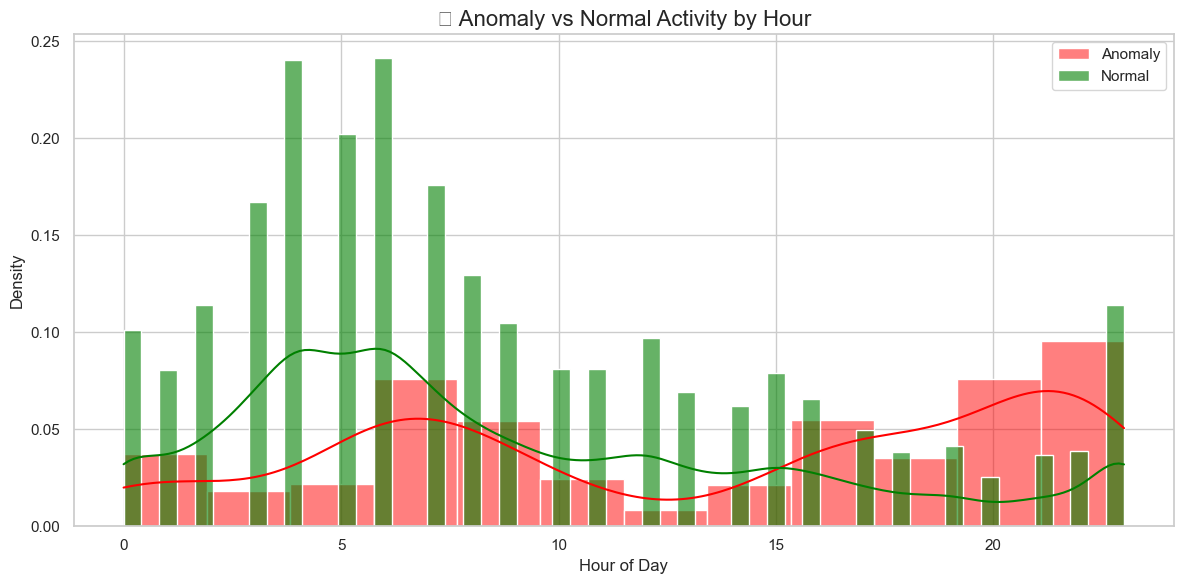

In [17]:
sns.histplot(df[df['iso_label'] == -1]['hour'], color='red', label='Anomaly', kde=True, stat='density')
sns.histplot(df[df['iso_label'] == 1]['hour'], color='green', label='Normal', kde=True, stat='density', alpha=0.6)
plt.title("⏰ Anomaly vs Normal Activity by Hour", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


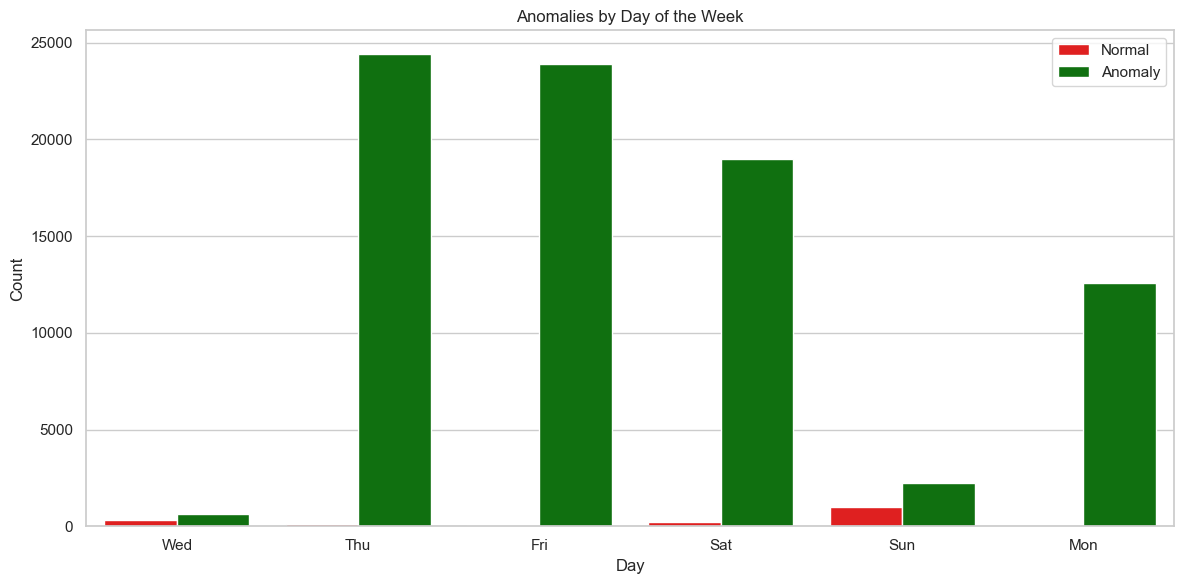

In [18]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_name'] = df['weekday'].map(lambda x: days[x])

sns.countplot(data=df, x='day_name', hue='iso_label', palette={1: 'green', -1: 'red'})
plt.title("Anomalies by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.legend(labels=['Normal', 'Anomaly'])
plt.tight_layout()
plt.show()


C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_18884\2472299677.py:12: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  plt.tight_layout()
C:\Users\Sivapriya\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


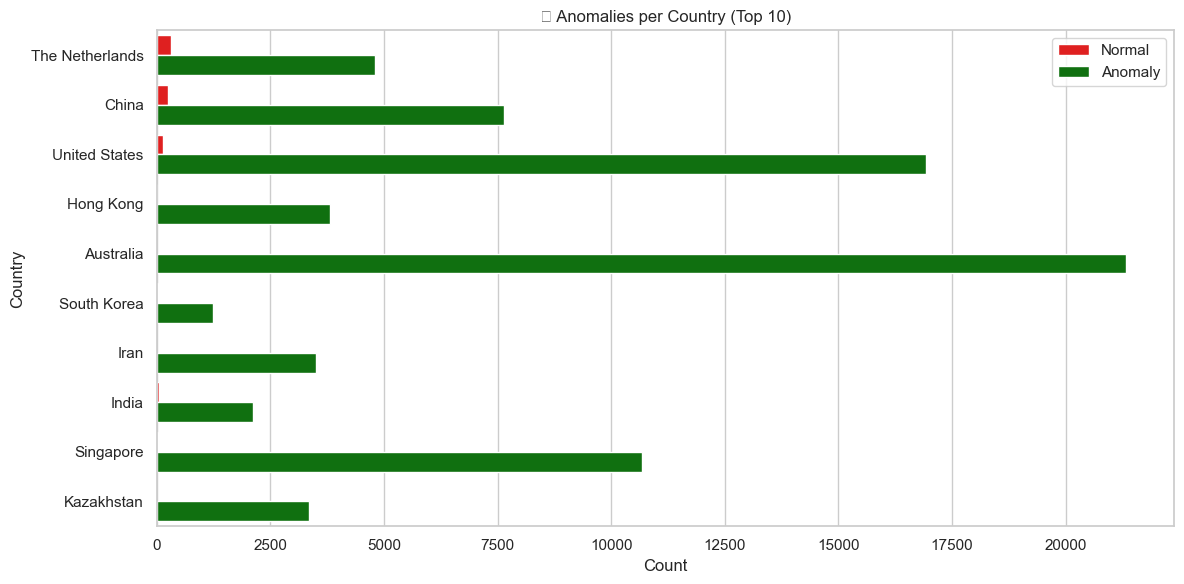

In [19]:
# Reverse label encoding for readability (optional)
df['CountryName'] = encoders['Country'].inverse_transform(df['Country'])

top_countries = df['CountryName'].value_counts().head(10).index
filtered_df = df[df['CountryName'].isin(top_countries)]

sns.countplot(data=filtered_df, y='CountryName', hue='iso_label', palette={1: 'green', -1: 'red'})
plt.title("🌍 Anomalies per Country (Top 10)")
plt.xlabel("Count")
plt.ylabel("Country")
plt.legend(labels=['Normal', 'Anomaly'])
plt.tight_layout()
plt.show()
